
## **CS-671 Assignment-2 : Task-2**
##### Author : [Chirag Vashist](https://github.com/SerChirag)
This notebook uses a multi-heads simple CNN for a multiclass classification task on a previously created line dataset. The model is built using the Keras non-sequential functional API.
<br>

**Problem Statement**

Design a non-sequential convolutional neural network for classifying the line dataset. This network will have 4 outputs based on the 4 kind of variations(length, width, color, angle).

 1. Colour-Head : Binary Cross-entropy loss with sigmoid activation. 
 2. Length-Head : Binary Cross-entropy loss with sigmoid activation. 
 3. Width-Head :Binary Cross-entropy loss with sigmoid activation.
 4. Angle-Head : Categorical Cross-entropy loss with softmax activation.


## Importing Libraries and Data-sets

In [1]:
import cv2
import numpy as np
import pydot

import keras.layers as KL
import keras.callbacks as KC
import keras.utils as KU
from keras.models import Model
from keras.optimizers import Adam
from keras import metrics
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline
map_class = np.load("map_class.npy").item()

Using TensorFlow backend.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2589081839043572136
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17957797660933308823
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
class Config():
    """Configuration 
    """
    IMG_SIZE = 28
    EPOCHS = 15
    
config = Config()

In [5]:
x_train = np.load("x_train.npy")
y_train = np.transpose(np.load("y_train.npy"))

In [6]:
y_length = y_train[0]
y_width = y_train[1]
y_colour = y_train[3]
y_angle = np.eye(12)[y_train[2]]

## Building Non-Sequential Model

In [7]:
def build_colour_head(x, label_nbr, last_layer_name):
    '''Build the head for binary classifier for Colour
    '''
    x = KL.Flatten()(x)
    x = KL.Dense(64, activation='relu')(x)
    x = KL.Dense(label_nbr,activation='sigmoid', name=last_layer_name)(x)
    return x;

def build_length_head(x, label_nbr, last_layer_name):
    '''Build the head for binary classifier for Length
    '''
    x = KL.Flatten()(x)
    x = KL.Dense(64, activation='relu')(x)
    x = KL.Dense(label_nbr,activation='sigmoid', name=last_layer_name)(x)
    return x;

def build_width_head(x, label_nbr, last_layer_name):
    '''Build the head for binary classifier for Width
    '''
    x = KL.Flatten()(x)
    x = KL.Dense(64, activation='relu')(x)
    x = KL.Dense(label_nbr,activation='sigmoid', name=last_layer_name)(x)
    return x;

def build_angle_head(x, label_nbr, last_layer_name):
    '''Build the head for multi-class classifier for Angle-Detection
    '''
    x = KL.Flatten()(x)
    x = KL.Dense(64, activation='relu')(x)
    x = KL.Dense(label_nbr)(x)
    x = KL.Activation('softmax', name=last_layer_name)(x)
    return x;

def build_model():
    '''Build model
    '''
    inputs = KL.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, 3))
    x = KL.ZeroPadding2D((3, 3))(inputs)
    x = KL.Conv2D(32, (3, 3), strides = (1, 1))(inputs)
    x = KL.BatchNormalization(axis = 3)(x)
    x = KL.Activation('relu')(x)
    x = KL.MaxPooling2D((2, 2))(x)
    x = KL.Dropout(0.25)(x)

    lengthBranch = build_length_head(x, 1, 'length')
    widthBranch = build_width_head(x, 1, 'width')
    angleBranch = build_angle_head(x, 12, 'angle')
    colourBranch = build_colour_head(x, 1, 'colour')

    return Model(
        inputs=inputs,
        outputs= [lengthBranch, widthBranch, angleBranch, colourBranch],
        name="multi_head_cls")


def prepare_model(model):
    '''Compile model
    '''
    losses = {
        "length": "binary_crossentropy",
        "width": "binary_crossentropy",
        "angle": "categorical_crossentropy",
        "colour": "binary_crossentropy",
        }

    lossWeights = {"length": 1.0, "width": 5.0, "angle": 9.0,  "colour": 1.0}
    
    metrices = {
        "length": "binary_accuracy",
        "width": "binary_accuracy",
        "angle": "categorical_accuracy",
        "colour": "binary_accuracy",
        }

    model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
                      loss=losses,
                      loss_weights=lossWeights,
                      metrics=metrices)

    
def train_model(model, data, y_length, y_width, y_angle, y_colour):
    '''
    Train model
    Compile the model

    Return:
    H -- history of training
    '''
    H = model.fit(
        data,
        {"length": y_length, "width": y_width, "angle": y_angle, "colour": y_colour},
        epochs=config.EPOCHS,
        batch_size=16)

    return H

In [8]:
model = build_model()
prepare_model(model)
H = train_model(model, x_train, y_length, y_width, y_angle, y_colour)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
72000/72000 [==============================] - 172s 2ms/step - loss: 7.5089 - length_loss: 0.0354 - width_loss: 0.0436 - angle_loss: 0.8055 - colour_loss: 0.0059 - length_binary_accuracy: 0.9894 - width_binary_accuracy: 0.9859 - angle_categorical_accuracy: 0.7356 - colour_binary_accuracy: 0.9989
Epoch 2/15
72000/72000 [==============================] - 175s 2ms/step - loss: 2.5770 - length_loss: 2.5730e-04 - width_loss: 0.0056 - angle_loss: 0.2831 - colour_loss: 5.8223e-04 - length_binary_accuracy: 1.0000 - width_binary_accuracy: 0.9984 - angle_categorical_accuracy: 0.9114 - colour_binary_accuracy: 0.9998
Epoch 3/15
72000/72000 [==============================] - 175s 2ms/step - loss: 1.4320 - length_loss: 2.8183e-05 - width_loss: 0.0033 - angle

## Analyzing Metrics 

In [12]:
plot_model(model, to_file='model_plot.png', show_layer_names=True) 

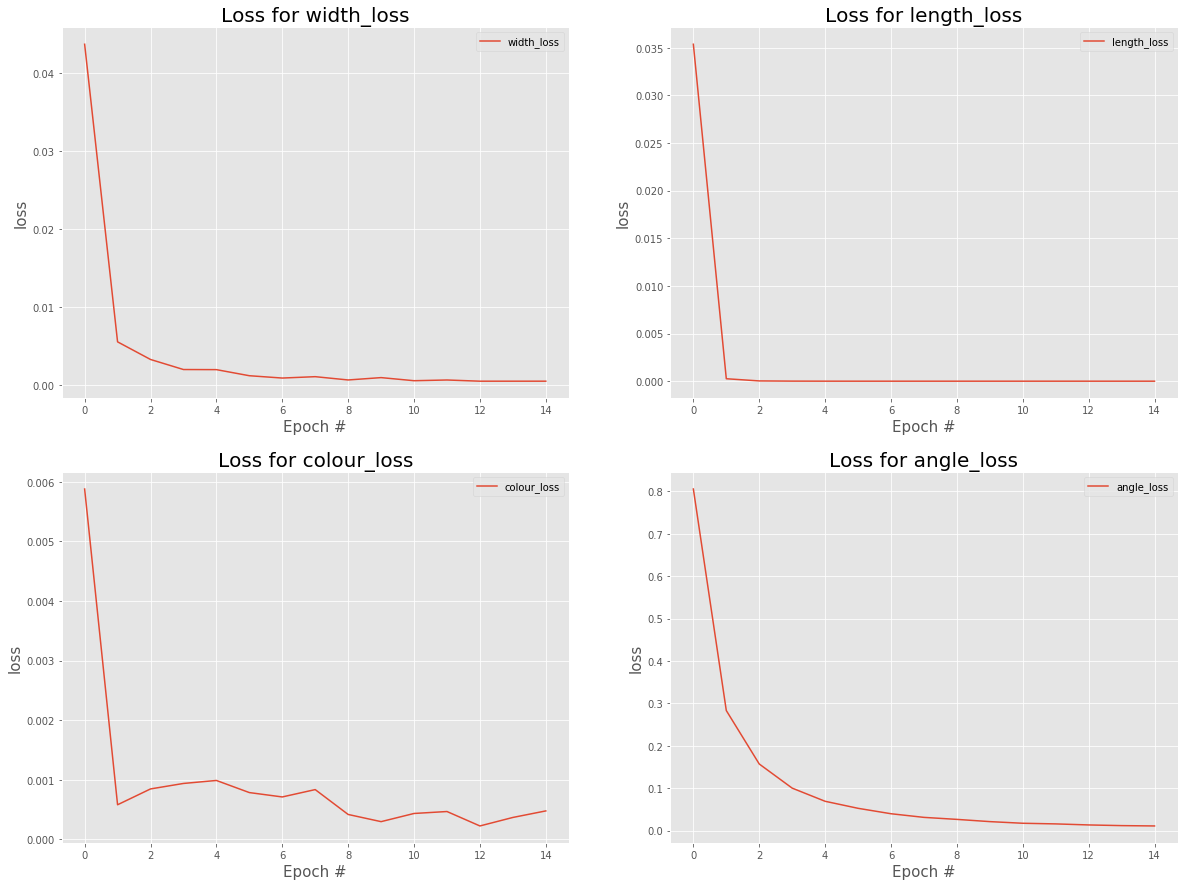

In [13]:
def analyse_results(epochs, history):
    '''plot metrics to analyse the learning evolution
    '''
    metrics = [
        'width_loss',
        'length_loss',
        'colour_loss',
        'angle_loss']
    
    plt.style.use("ggplot")
    rows = 2
    (fig, ax) = plt.subplots(2, 2, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for (i, l) in enumerate(metrics):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i//(rows),i%rows].set_title(title, fontsize=20)
        ax[i//(rows),i%rows].set_xlabel("Epoch #",fontsize=15)
        ax[i//(rows),i%rows].set_ylabel(l.split('_')[-1],fontsize=15)
        ax[i//(rows),i%rows].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i//(rows),i%rows].legend()
        
analyse_results(config.EPOCHS, H)

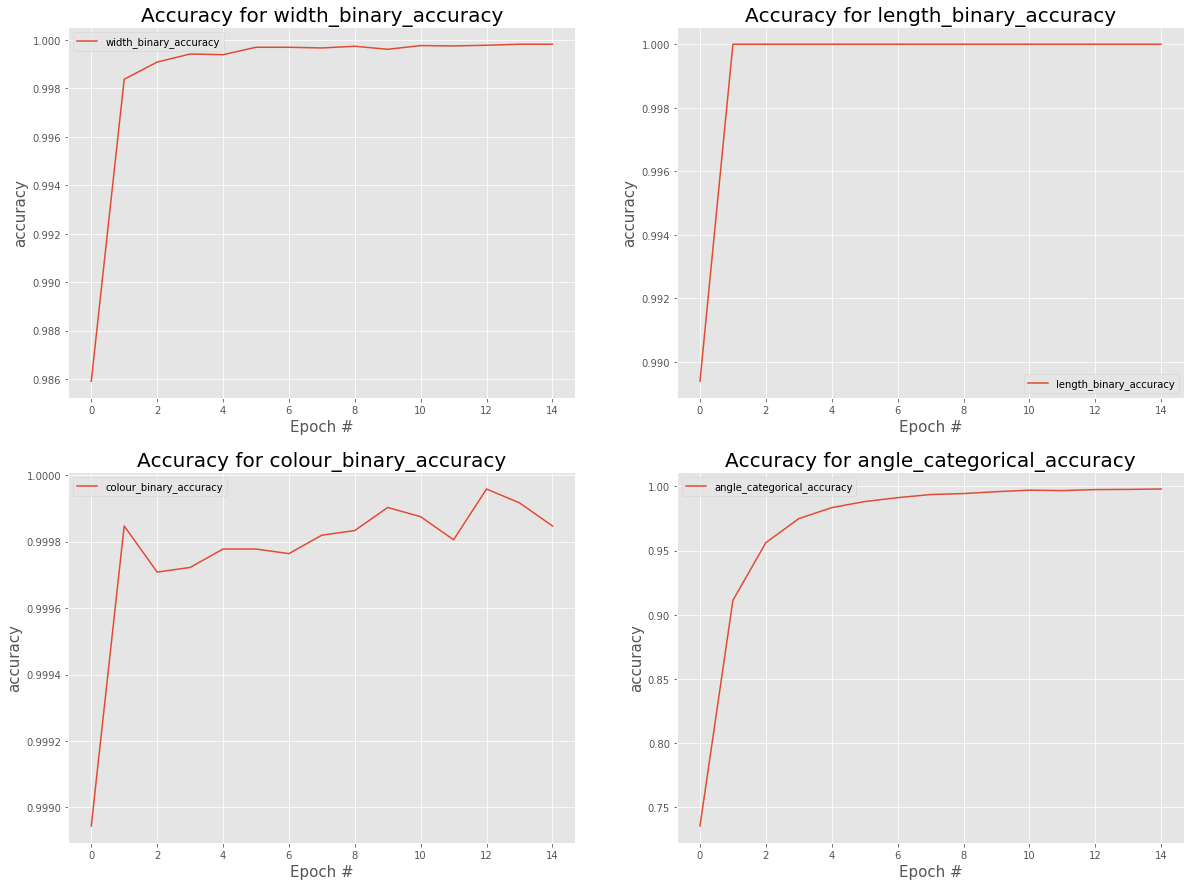

In [14]:
def analyse_results(epochs, history):
    '''plot metrics to analyse the learning evolution
    '''
    metrics = [
        'width_binary_accuracy',
        'length_binary_accuracy',
        'colour_binary_accuracy',
        'angle_categorical_accuracy']
    
    plt.style.use("ggplot")
    rows = 2
    (fig, ax) = plt.subplots(2, 2, figsize=(20, 15))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for (i, l) in enumerate(metrics):
        title = "Accuracy for {}".format(l) if l != "loss" else "Total loss"
        ax[i//(rows),i%rows].set_title(title, fontsize=20)
        ax[i//(rows),i%rows].set_xlabel("Epoch #",fontsize=15)
        ax[i//(rows),i%rows].set_ylabel(l.split('_')[-1],fontsize=15)
        ax[i//(rows),i%rows].plot(np.arange(0, epochs), history.history[l], label=l)
        ax[i//(rows),i%rows].legend()
        
analyse_results(config.EPOCHS, H)

## Testing on validation-set

In [9]:
x_test = np.load("x_test.npy")
y_test = np.transpose(np.load("y_test.npy"))
y_length = y_test[0]
y_width = y_test[1]
y_colour = y_test[3]
y_angle = np.eye(12)[y_test[2]]
predict = model.predict(x_test)

In [10]:
confusion_matrix = np.zeros((96,96),dtype=int)
for i in range(len(x_test)):
    y_actual = str(y_test[0][i])+"_"+str(y_test[1][i])+"_"+str(y_test[2][i])+"_"+str(y_test[3][i])
    y_pred_l = str(int(round(predict[0][i])))
    y_pred_w = str(int(round(predict[1][i])))
    y_pred_c = str(int(round(predict[3][i])))
    y_pred_a = str(int(predict[2][i].argmax()))
    y_pred = y_pred_l+"_"+y_pred_w+"_"+y_pred_a+"_"+y_pred_c
    y_actual_int = map_class[y_actual]
    y_pred_int = map_class[y_pred]
    confusion_matrix[y_actual_int][y_pred_int] += 1

In [11]:
accuracy = np.trace(confusion_matrix)/(1.0*np.sum(confusion_matrix))
print accuracy*100

100.0


In [ ]:
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
fscore = (2*recall*precision)/(recall + precision)

Text(0,0.5,'F-Score')

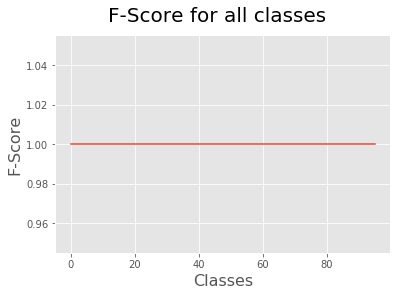

In [40]:
fig = plt.figure()
plt.plot(fscore)
fig.suptitle('F-Score for all classes', fontsize=20)
plt.xlabel('Classes', fontsize=16)
plt.ylabel('F-Score', fontsize=16)